# SMOTE (Synthetic Minority Oversampling Technique) for data generation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imblearn
import scipy
import scipy.stats as stats
from scipy.stats.stats import pearsonr

## 1. Loading Data

In [3]:
%%sh
ls -laFh ../data/statistical-generative-modeling-sample.csv.bz2

-rw-r--r-- 1 auriane auriane 4,4M juil.  7 14:58 ../data/statistical-generative-modeling-sample.csv.bz2


In [4]:
df = pd.read_csv("../data/statistical-generative-modeling-sample.csv.bz2")

In [5]:
df

,SEATS,PASSENGERS,FREIGHT,DISTANCE,RAMP_TO_RAMP,AIR_TIME,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,AIRCRAFT_TYPE,MONTH,Unnamed: 14
0,0.0,0.0,331088.0,216.0,1708.0,780.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12402,ITO,620,6,NaN
1,0.0,0.0,1081490.0,163.0,5695.0,1782.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12758,KOA,620,6,NaN
2,0.0,0.0,570900.0,102.0,2006.0,884.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12982,LIH,620,6,NaN
3,0.0,0.0,1206131.0,100.0,6146.0,1704.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,13830,OGG,620,6,NaN
4,0.0,0.0,180778.0,216.0,2135.0,1092.0,1TQ,Rhoades Aviation dba Transair,12402,ITO,12173,HNL,620,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394121,105984.0,81424.0,511764.0,100.0,34737.0,17951.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,3,NaN
394122,106368.0,74321.0,143112.0,100.0,33693.0,19865.0,HA,Hawaiian Airlines Inc.,13830,OGG,12173,HNL,608,10,NaN
394123,106752.0,71430.0,600636.0,100.0,35319.0,18013.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,10,NaN
394124,107904.0,77703.0,478682.0,100.0,34822.0,18338.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,5,NaN


In [6]:
reduced_size = 500

In [7]:
df_sample = df[["DISTANCE", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]][:reduced_size]

In [8]:
df_sample

,DISTANCE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,216.0,12173,12402
1,163.0,12173,12758
2,102.0,12173,12982
3,100.0,12173,13830
4,216.0,12402,12173
...,...,...,...
495,122.0,10551,14282
496,145.0,10551,14718
497,38.0,10551,15257
498,117.0,10551,15282


## 2. Useful functions

In [9]:
def compute_neighbors(elem, target_list, k):
    distances_neighbors = []
    for i in range (len(target_list)):
        distances_neighbors.append([np.linalg.norm(target_list[i] - elem),  i])
    distances_neighbors = sorted(distances_neighbors, key=lambda x: x[0])
    nearest_neighbors_indexes = distances_neighbors[:k]
    nearest_neighbors = []
    for index in range(len(nearest_neighbors_indexes)):
        nearest_neighbors.append(target_list[nearest_neighbors_indexes[index][1]])
    return nearest_neighbors

In [10]:
def standardize_data(X):
    """
    returns reduced and centered data
    """
    X2 = X.copy()
    for j in range(len(X2[0])):
        X2[:,j] = X2[:,j] - np.mean(X2[:,j])
        X2[:,j] = X2[:,j] / (np.std(X2[:,j]) + 1*10**-16)
    return X2

In [24]:
def destandardize_data(X, mean, std):
    """
    returns reduced and centered data
    """
    X2 = X.copy()
    for j in range(len(X2[0])):
        
        #X2[:,j] = X2[:,j] * (df_sample_num.std()[j])
        #X2[:,j] = X2[:,j] + df_sample_num.mean()[j]
        X2[:,j] = X2[:,j] * std[j]
        X2[:,j] = X2[:,j] + mean[j]
       
    return X2

In [12]:
def gauss_truncated(lower, upper, mu, sigma):
    
    """
    Computes a value according to a gaussian truncated distribution
    :param lower: (float) lower bound  
    :param upper: (float) upper bound
    :param mu: (float) mean of the gaussian
    :param sigma: (float) standard deviation of the gaussian
    :return: (float) x, value drawn according to gaussian truncated distribution
    """
    
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    x = X.rvs()
    return x

In [13]:
def remove_ticks(ax):
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
def remove_splines(ax, spl):
    for s in spl:
        ax.spines[s].set_visible(False)  

def modify_splines(ax, lwd, col):    
    for s in ['bottom', 'left','top','right']:
        ax.spines[s].set_linewidth(lwd)
        ax.spines[s].set_color(col)

## 3. Data pre-processing

In [14]:
def categorical_to_numerical(df, categorical_fields):
    
    
    """
    Converts categorical data attributes to numerical
    :param df: initial pandas data-frame  
    :param categorical_fields: list of strings (attributes names that will be converted from categorical
    to numerical
    :return:  dictionary where keys are names of numerical fields computed from categorical, and values are
    pandas data-frames with sorted categorical values and corresponding intervals
    """
    

    transitional_dfs = {}
    df_categorical = df.copy()
    
    for categorical_field in categorical_fields:
        
        assert (categorical_field in df), "This field doesn't exist in the database"

        # adding empty column for new numerical field
        df_categorical[categorical_field + "_NUM"] = 0

        #data-frame of unique discrete values from categorical field and associated proportions (decreasing order)
        unique_values_df = df[categorical_field\
                             ].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
        
        # building the intervals
        unique_values_df["interval_down"] = ""
        unique_values_df["interval_up"] = ""
        for index, row in unique_values_df.iterrows():
            if index == 0:
                unique_values_df.loc[index, "interval_down"] = 0
                unique_values_df.loc[index, "interval_up"] = row["counts"]   
            else:
                unique_values_df.loc[index, "interval_down"] =  \
                    unique_values_df[index-1:index]["interval_up"].item()
                unique_values_df.loc[index, "interval_up"] = \
                    unique_values_df[index-1:index]["interval_up"].item() + row["counts"]
        
        transitional_dfs[categorical_field + "_NUM"] = unique_values_df
        
        # filling new numerical column
        for index, row in df.iterrows():
            value = row[categorical_field]
            i = unique_values_df[unique_values_df["unique_values"] == value].index.tolist()[0]

            # drawing value from truncated gaussian distribution
            a = unique_values_df[i:i+1]["interval_down"].item()
            b = unique_values_df[i:i+1]["interval_up"].item()
            mu = a + (b-a)/2
            sigma = (b-a)/6
            x = gauss_truncated(a, b, mu, sigma)
            df_categorical.loc[index, categorical_field + "_NUM"] = x
        df_categorical = df_categorical.drop(categorical_field, axis=1)
        
    return df_categorical, transitional_dfs

In [15]:
categorical_fields = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]

In [16]:
df_sample_num, transitional_dfs = categorical_to_numerical(df_sample, categorical_fields)

In [17]:
df_sample_num

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,216.0,0.425153,0.492314
1,163.0,0.416663,0.502515
2,102.0,0.415599,0.535522
3,100.0,0.422827,0.445211
4,216.0,0.536122,0.241899
...,...,...,...
495,122.0,0.275808,0.920806
496,145.0,0.264635,0.994966
497,38.0,0.252506,0.897450
498,117.0,0.261174,0.768652


## 4.    Modeling and generation

In [18]:
class Distribution(object):
    
    
    """
    Given an initial set of data, computes the best fitted distribution and corresponding parameters 
    from predefined list of known distributions
    """
    
    
    def __init__(self,distr_names_list=["norm", "lognorm", "expon", "uniform", "truncnorm", \
                                       "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]):
        self.distr_names = distr_names_list
        self.distr_results = []
        self.params = {}
        self.distribution_name = ""
        self.pvalue = 0
        self.param = None
        self.is_fitted = False
        
        
    def fit(self, initial_data):
        
        """
        :param initial_data: pandas series of initial data that has to be fitted 
        :return: name of the distribution that fits the best and associated p value (computed by ks test)
        """
        
        #going through all distributions
        for distr_name in self.distr_names:
            
            # best parameters for this distribution
            distr = getattr(stats, distr_name)
            param = distr.fit(initial_data)
            self.params[distr_name] = param
            
            #Kolmogorov-Smirnov test for these parameters
            D, p = stats.kstest(initial_data, distr_name, args=param)
            self.distr_results.append((distr_name,p))
            
        #select the best fitted distribution
        best_distr, best_p = (max(self.distr_results,key=lambda tup:tup[1]))
        
        #store the name of the best fit and its p value and parameters
        self.distribution_name = best_distr
        self.pvalue = best_p
        self.param = self.params[best_distr]
        self.is_fitted = True
        
        return self.distribution_name, self.pvalue
    
    
    def random(self, n = 1):
        
        """
        :param n: int, number of samples that will be drawn according to the best fitted distribution
        :return: array of samples drawn according to the best fitted distribution
        """
        
        if self.is_fitted:
            param = self.params[self.distribution_name]
            distr = getattr(scipy.stats, self.distribution_name)
            return distr.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the fit method.')
          
        
    def plot(self,initial_data, name, ax, fitted_distr=True, lab="Actual"):
        
        """
        :param initial_data: pandas series of initial data that has to be fitted
        :param name: string of the name of the attribute that is being fitted
        :pram ax: matplotlib ax for display
        :param fitted_distr: bool (indicates is fitted distribution is plotted on top of initial distribution)
        :param lab: string, label for initial data
        """  
        
        # for graphic view
        remove_ticks(ax)
        modify_splines(ax, lwd=0.75, col='0.8')
        remove_splines(ax, ['top','right'])
        ax.patch.set_facecolor('0.93')
        ax.grid(True, 'major', color='0.98', linestyle='-', linewidth=1.0)
        ax.set_axisbelow(True)
        
        
        x = self.random(n=len(initial_data))
        if fitted_distr:
            ax.hist(x, bins=30, alpha=0.4, label='Fitted', density=True, ec="k", histtype='stepfilled')
        ax.hist(initial_data, bins=30, alpha=0.4, label=lab, density=True, ec="k", histtype='stepfilled')
        ax.set_title(name)
        ax.legend(loc='upper right')

In [19]:
class Model():
    
    """
    Computes the generative model from an initial data-frame
    """
    
    def __init__(self, dataframe):
        self.df = dataframe
        self.df_normed = pd.DataFrame(columns=self.df.columns)
        self.distributions = {}
        self.distr_computed = False
        
        
    def compute_distributions(self, display_results=True):
        
        """
        Computes the best fitted distribution for each attribute and prints its name, associated p value
        (computed from ks test), and parameters
        :param display_results: bool that indicates whether information on the fitted distribution will be printed
        """
        
        for attribute in self.df:
            distr= Distribution()
            distr.fit(self.df[attribute])
            self.distributions[attribute] = distr
            self.distr_computed = True
            if display_results:
                print("The distribution that fits the best attribute "+ attribute + " is "+ distr.distribution_name)
                print("The pvalue is", distr.pvalue, " with the following parametrers:", distr.param)
                print("\n")
        
        
    def plot_distributions(self, fitted_distr=True, lab="Actual"):
        
        """
        Plots the distribution of each attribute of the main data-frame
        :param fitted_distr: bool (indicates is fitted distributions will be plotted on top of 
        initial distributions)
        :param lab: string, label for initial data
        """
        
        if self.distr_computed:
            for attribute in self.df:
                fig, ax = plt.subplots()
                self.distributions[attribute].plot(self.df[attribute], attribute, ax, fitted_distr, lab)
                plt.show()
        else:
            raise ValueError('Must compute the distributions first.')
            
            

In [25]:
class smote_model(Model):
    
    def generate_data(self, k):
        
        self.df_gen = np.zeros(self.df.shape)
        
        self.df_norm = standardize_data(self.df.to_numpy())
        self.df_norm = pd.DataFrame(self.df_norm)
        
        for index, row in self.df_norm.iterrows():
           
            row = row.to_numpy()
            row_others = np.delete(self.df_norm.to_numpy(), index, axis=0)
            
            neigh = compute_neighbors(row, row_others, k)
            rand = np.random.randint(k-1)
            selected_neigh = neigh[rand]
           

            new_point = row + np.random.rand(1)[0] *(selected_neigh - row)
            self.df_gen[index] = new_point
        self.df_gen = pd.DataFrame(self.df_gen)
            
        self.df_gen = destandardize_data(self.df_gen.to_numpy(), self.df.mean(), self.df.std())
        self.df_gen = pd.DataFrame(data = self.df_gen, columns = self.df.columns)
    


In [26]:
Mod = smote_model(df_sample_num)

In [27]:
k=5

In [28]:
Mod.generate_data(k)

In [29]:
df_gen = Mod.df_gen

## 5. Quality assessment

In [38]:
class closeness():
    
    """
    Graphical display of closeness between original and generated data 
    """
    
    def __init__(self, init, gen):
        self.initial_df = init
        self.generated_df = gen
        self.correlations = {}
      
        
    def computes_correlations(self):
        
        """
        Computes in numpy arrays pairwise Pearson correlation coefficients for initial and generated data
        """
        
        self.correlations["initial"] = np.zeros((len(self.initial_df.columns), len(self.initial_df.columns)))
        self.correlations["generated"] = np.zeros((len(self.generated_df.columns), len(self.generated_df.columns)))
    
        # pairwise coefficients for initial data
        for index1, col1 in enumerate(self.initial_df.columns):
            for index2, col2 in enumerate(self.initial_df.columns):
                self.correlations["initial"][index1, index2] = pearsonr(self.initial_df[col1].to_numpy(), \
                                                                        self.initial_df[col2].to_numpy())[0]
        # pariwise coefficients for generated data
        for index1, col1 in enumerate(self.generated_df.columns):
            for index2, col2 in enumerate(self.generated_df.columns):
                self.correlations["generated"][index1, index2] = pearsonr(self.generated_df[col1].to_numpy(), \
                                                                          self.generated_df[col2].to_numpy())[0]
            
         
    def set_ax_heatmap(self, ax, hmap, absc, ordo, title):
        
        """
        Sets ax in order to compute 2D heatmap
        :param ax: matplotlib ax for display
        :param hmap: 2D numpy array of pariwise pearson correlation coefficients
        :param absc, ordo: list of strings (column names)
        :param title: string (title of ax for display)
        :return: matplotlib ax with adjustments for display
        """
        
        ax.set_xticks(np.arange(len(absc)))
        ax.set_yticks(np.arange(len(ordo)))
        
        # labels
        ax.set_xticklabels(absc)
        ax.set_yticklabels(ordo)

        # Rotation and alignment of xlabels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # displaying actual values
        for i in range(len(absc)):
            for j in range(len(ordo)):
                text = ax.text(j, i, np.round(hmap[i, j], 2), ha="center", va="center", color="w")
        
        # title
        ax.set_title(title)
        
        return ax
    
    
   
    def pearson_plot(self):
        
        """
        Computes a 2D heatmap of pairwise Pearson correlations 
        """
        
        # computing correlation matrices
        self.computes_correlations()
        
        # labels for axes
        absc1, absc2 = self.initial_df.columns, self.generated_df.columns
        ordo1, ordo2 = self.initial_df.columns, self.generated_df.columns
        
        # computing heatmaps
        hmap1, hmap2 = self.correlations["initial"], self.correlations["generated"]
        
        # displaying the results
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0] = self.set_ax_heatmap( ax[0], hmap1, absc1, ordo1, "Initial pairwise Pearson correlations")
        ax[1] = self.set_ax_heatmap( ax[1], hmap2, absc2, ordo2, "Generated pairwise Pearson correlations")
        fig.tight_layout()
        ax[0].imshow(hmap1, cmap=plt.cm.pink, alpha=0.9)
        ax[1].imshow(hmap2, cmap=plt.cm.pink, alpha=0.9)
        
        
    def variables_scatter_plot(self):
        
        """
        Computes scatter plots between first attribute and all of the others for initial and generated sets
        """
        
        ref_col1 = self.initial_df.columns[0]
        ref_col2 = self.generated_df.columns[0]
        fig, axes = plt.subplots(len(self.initial_df.columns) - 1, 2, figsize=(8, 8))
        
        # scatter plots for intial data
        for index, col in enumerate(self.initial_df.columns[1:]):
            axes[index][0].scatter(self.initial_df[ref_col1], self.initial_df[col])
            axes[index][0].set_ylabel(col)
        
        # scatter plots for generated data
        for index, col in enumerate(self.generated_df.columns[1:]):
            axes[index][1].scatter(self.generated_df[ref_col2], self.generated_df[col])
         
        # common abscissa axis label (first attribute) 
        plt.setp(axes[-1, :], xlabel=ref_col1)
        
        # column titles
        for ax, col in zip(axes[0], ["Original", "Generated"]):
            ax.set_title(col)
     
        fig.tight_layout()
        
        
    def compare_distributions(self):
        Mod = Model(self.initial_df)
        Mod_gen = Model(self.generated_df)
        
        Mod.compute_distributions(display_results=False)
        Mod_gen.compute_distributions(display_results=False)
        
        for attribute in self.initial_df:
            fig, ax = plt.subplots()
            Mod_gen.distributions[attribute].plot(Mod_gen.df[attribute], attribute, ax, fitted_distr=False, lab="Generated data")
            Mod.distributions[attribute].plot(Mod.df[attribute], attribute, ax, fitted_distr=False, lab="Initial data")
            plt.show()

       

        

In [39]:
df_sample_num

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,216.0,0.425153,0.492314
1,163.0,0.416663,0.502515
2,102.0,0.415599,0.535522
3,100.0,0.422827,0.445211
4,216.0,0.536122,0.241899
...,...,...,...
495,122.0,0.275808,0.920806
496,145.0,0.264635,0.994966
497,38.0,0.252506,0.897450
498,117.0,0.261174,0.768652


In [40]:
df_gen

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,181.392462,0.422332,0.504336
1,109.761165,0.415971,0.528468
2,133.679958,0.418197,0.517528
3,153.685752,0.420876,0.493758
4,124.022239,0.518371,0.247733
...,...,...,...
495,123.710222,0.275211,0.919161
496,159.380629,0.272314,0.981011
497,35.924230,0.252799,0.898033
498,116.337618,0.261306,0.768844


In [41]:
res = closeness(df_sample_num, df_gen)

/home/auriane/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


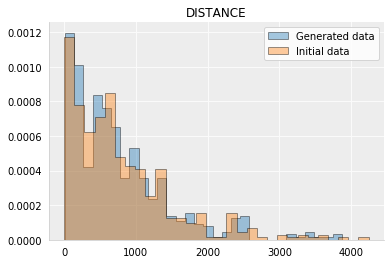

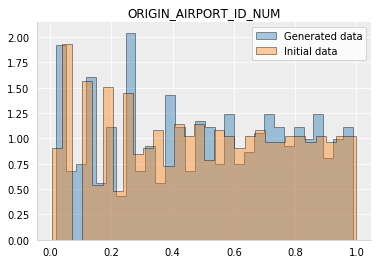

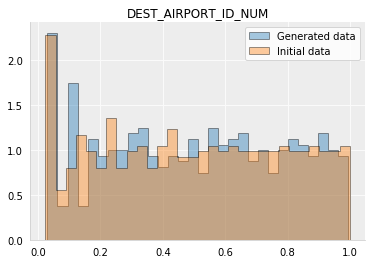

In [42]:
res.compare_distributions()

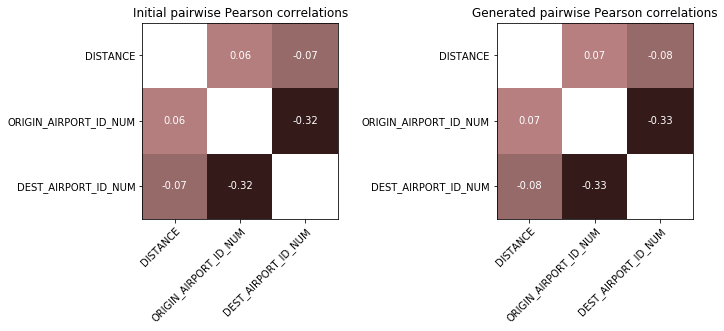

In [43]:
res.pearson_plot()

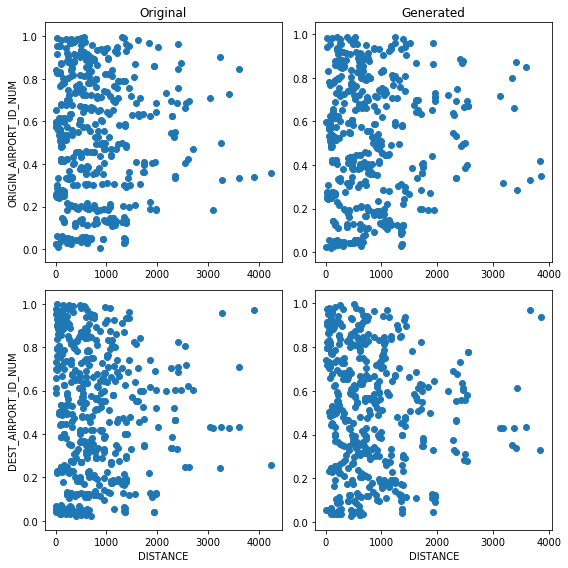

In [44]:
res.variables_scatter_plot()

In [37]:
"""plt.scatter(X_new[:,0], X_new[:,1], c = Y_new)
plt.suptitle('Initial samples for linear method')

k=3
for i, point in enumerate(X_new):
    print("poin", point)
    X_else = np.delete(X_new, i, axis=0)
    neigh = compute_neighbors(point, X_else, k)
    rand = np.random.randint(k-1)
    selected_neigh = neigh[rand]
    
    new_point = point + np.random.rand(1)[0] *(selected_neigh - point)
    
    plt.scatter(X_new[:,0], X_new[:,1], c = Y_new)
    plt.scatter(np.array(neigh)[:,0], np.array(neigh)[:,1], c = "g")
    plt.scatter(point[0], point[1], c="r")
    plt.scatter(new_point[0], new_point[1], c="y")
    plt.show()
    gen[i] = new_point
    print("neigh", neigh)"""

'plt.scatter(X_new[:,0], X_new[:,1], c = Y_new)\nplt.suptitle(\'Initial samples for linear method\')\n\nk=3\nfor i, point in enumerate(X_new):\n    print("poin", point)\n    X_else = np.delete(X_new, i, axis=0)\n    neigh = compute_neighbors(point, X_else, k)\n    rand = np.random.randint(k-1)\n    selected_neigh = neigh[rand]\n    \n    new_point = point + np.random.rand(1)[0] *(selected_neigh - point)\n    \n    plt.scatter(X_new[:,0], X_new[:,1], c = Y_new)\n    plt.scatter(np.array(neigh)[:,0], np.array(neigh)[:,1], c = "g")\n    plt.scatter(point[0], point[1], c="r")\n    plt.scatter(new_point[0], new_point[1], c="y")\n    plt.show()\n    gen[i] = new_point\n    print("neigh", neigh)'